# Reward shaping analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import tri
from rlgym.utils import common_values
from utils.analysis.reward_functions import common, extra

## Arena plot

The corner points provide us with the entire arena top-level plot grid

In [2]:
def make_arena(refiner_sub_div=8):
    # *Facing orange goal*

    # X, right is minus
    x0 = - common_values.SIDE_WALL_X
    x1 = common_values.SIDE_WALL_X
    # Y, back is minus
    y0 = - common_values.BACK_WALL_Y
    y1 = common_values.BACK_WALL_Y
    # Z, up is plus
    z0 = 0
    z1 = common_values.CEILING_Z

    # Corner walls, corner near goal is first element
    corner_offset = 1152
    # right corner back
    right_corner0 = np.array([[x0 + corner_offset, y0], [x0, y0 + corner_offset]])
    # left corner back
    left_corner0 = np.array([[x1 - corner_offset, y0], [x1, y0 + corner_offset]])
    # right corner front
    right_corner1 = np.array([[x0 + corner_offset, y1], [x0, y1 - corner_offset]])
    # left corner front
    left_corner1 = np.array([[x1 - corner_offset, y1], [x1, y1 - corner_offset]])

    x = np.array([right_corner0[:, 0], left_corner0[:, 0], right_corner1[:, 0], left_corner1[:, 0]]).flatten()
    y = np.array([right_corner0[:, 1], left_corner0[:, 1], right_corner1[:, 1], left_corner1[:, 1]]).flatten()

    triang = tri.Triangulation(x, y)
    refiner = tri.UniformTriRefiner(triang)
    return refiner.refine_triangulation(subdiv=refiner_sub_div)

In [3]:
arena = make_arena()
print(arena.triangles)

[[     1  49665  65057]
 [ 12545 135938  49665]
 [ 16401  65057 135938]
 ...
 [ 34176 135936 111360]
 [ 49664 197632 135936]
 [111360 135936 197632]]


In [4]:
boost_locations = np.array(common_values.BOOST_LOCATIONS)

In [5]:
def arena_contour(z, figsize=(12, 12), boost_pad_size=128):
    plt.figure(figsize=figsize)
    arena_plot = plt.tricontourf(arena, z)
    plt.scatter(boost_locations[:, 0], boost_locations[:, 1], c="orange", marker="P", s=boost_pad_size,
                label="Boost pads")
    plt.legend()
    plt.colorbar(arena_plot)
    plt.show()

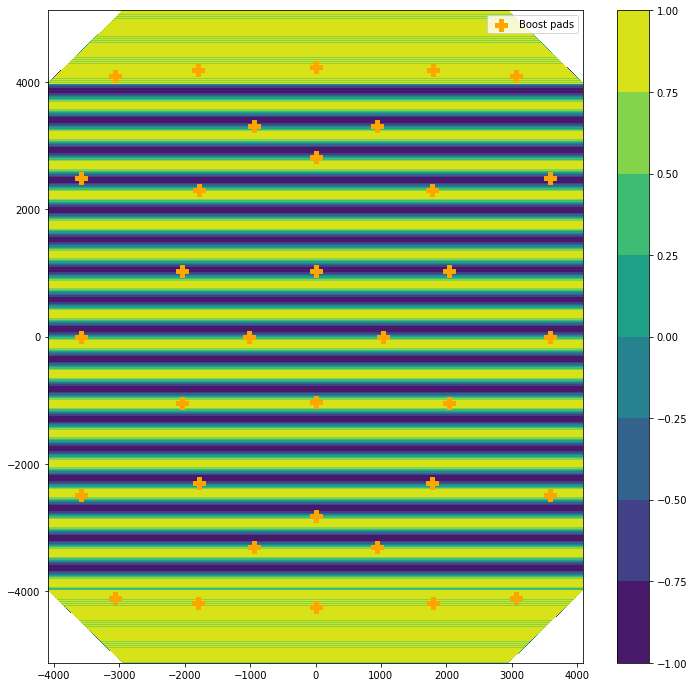

In [6]:
# right is orange goal, left is blue goal
z_dummy = np.sin(arena.y)
arena_contour(z_dummy)

## Rewards

### Common rewards

#### Ball2Goal

In [7]:
ball_positions = np.stack([arena.x, arena.y], -1)
ball_positions = np.append(ball_positions, np.ones((ball_positions.shape[0], 1)) * 300, -1)
ball_positions.shape

(197633, 3)

##### Distance to ball

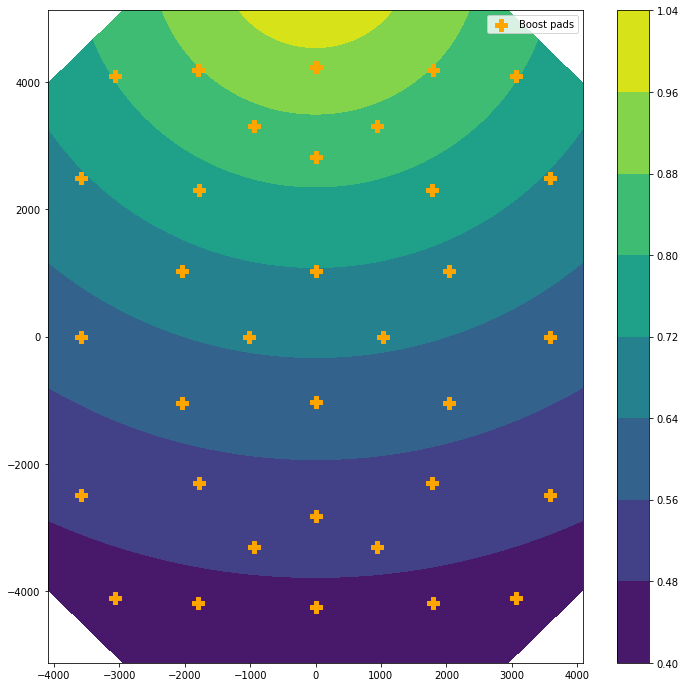

In [8]:
ball_zs = common.ball_goal.liu_dist_ball2goal(ball_positions)
arena_contour(ball_zs)

#####  Distance from goal wall

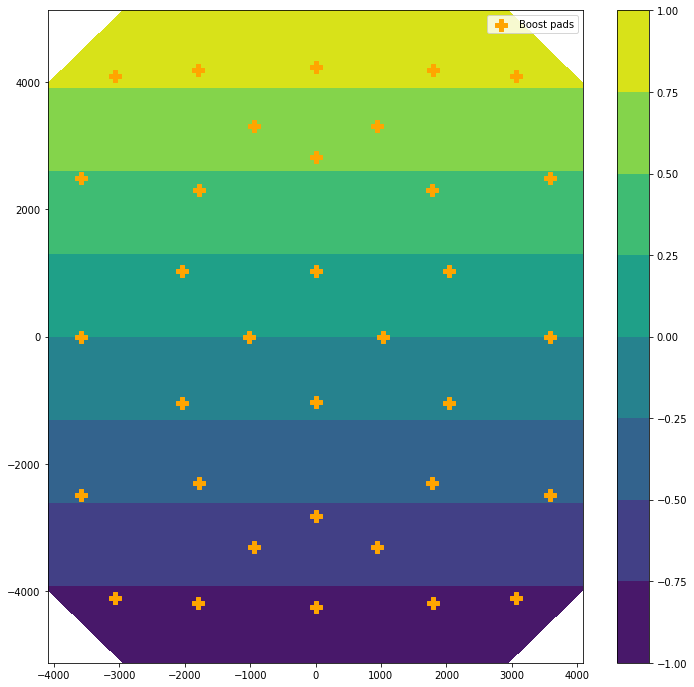

In [9]:
ball_zs = common.ball_goal.ball_y_coord(ball_positions)
arena_contour(ball_zs)

##### Ball to goal velocity

You can mess around with the values of ball linear velocity. First axis is the x axis (side to side), second is y (goal to goal), third is z (up/down).

In [36]:
# Note: ball maximum linear velocity is 6000, any more is not reflective of reality
ball_lin_velocity = np.array([0, 6000, -40], dtype=float)

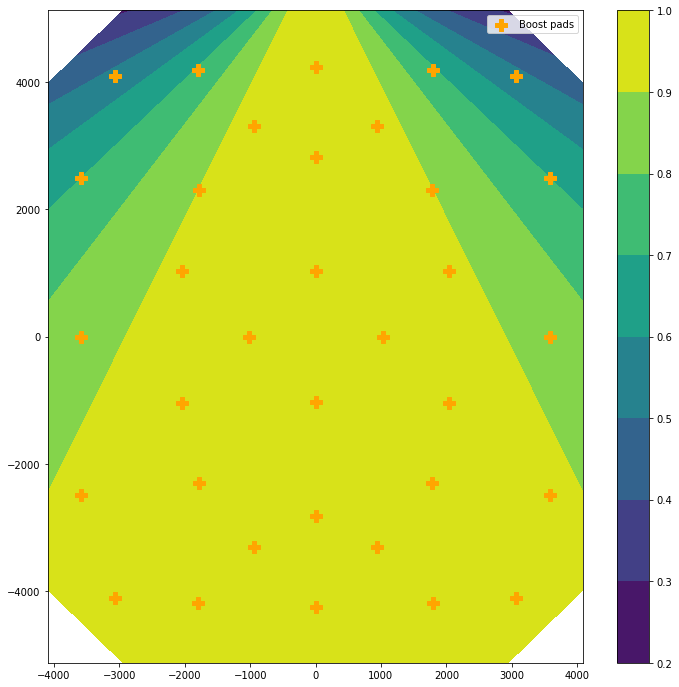

In [37]:
ball_zs = common.ball_goal.velocity_ball2goal(ball_positions, ball_lin_velocity)
arena_contour(ball_zs)

#### Conditional

#### Misc

#### Player2ball